In [1]:
import pandas as pd
import requests
from io import StringIO
import os
from dotenv import load_dotenv
import matplotlib.pyplot  as plt
import seaborn as sns
from datetime import date
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN



In [2]:
load_dotenv()

True

# Lectura y Preparación

In [3]:

#
myurl = os.environ["DETALLE_TAREAS_FULL_URL"] + "?" + os.environ["AZURE_DATALAKE_GENAI_TOKEN"]
df = pd.read_parquet(myurl)
#df = pd.read_parquet("data\\DETALLE_TAREAS_COMPLETO.parquet")
#df


In [4]:
df["FECHA_CIERRE"]=pd.to_datetime(df.FECHA_CIERRE,yearfirst=True,dayfirst=True)
df["DIA_SEMANA"]=df.FECHA_CIERRE.dt.day_of_week+1
df["DIA_SEMANA_NOM"]=df.FECHA_CIERRE.dt.day_name()
df["DIA_MES"]=df.FECHA_CIERRE.dt.days_in_month
df


,FECHA_CIERRE,CODIGO_TAREA,DESCRIPCION_TAREA,INICIO,FIN,DURACION_SEGUNDOS,DURACION,DIA_SEMANA,DIA_SEMANA_NOM,DIA_MES
0,2024-07-24,PX999C17,Depuracion del FSC017,2024-07-25 03:36:06,2024-07-25 03:36:08,2.0,00:00:02,3,Wednesday,31
1,2024-11-05,PX999C17,Depuracion del FSC017,2024-11-06 05:14:46,2024-11-06 05:14:47,1.0,00:00:01,2,Tuesday,30
2,2024-11-06,PX999C17,Depuracion del FSC017,2024-11-07 03:26:57,2024-11-07 03:26:58,1.0,00:00:01,3,Wednesday,30
3,2024-11-07,PX999C17,Depuracion del FSC017,2024-11-08 03:11:20,2024-11-08 03:11:21,1.0,00:00:01,4,Thursday,30
4,2024-11-08,PX999C17,Depuracion del FSC017,2024-11-09 02:30:38,2024-11-09 02:30:39,1.0,00:00:01,5,Friday,30
...,...,...,...,...,...,...,...,...,...,...
12505,2024-11-15,PCSMI001B,Rendicion Batch,2024-11-16 02:36:57,2024-11-16 02:36:58,1.0,00:00:01,5,Friday,30
12506,2024-11-16,PCSMI001B,Rendicion Batch,2024-11-17 01:40:20,2024-11-17 01:40:21,1.0,00:00:01,6,Saturday,30
12507,2024-11-18,PCSMI001B,Rendicion Batch,2024-11-19 03:02:57,2024-11-19 03:02:58,1.0,00:00:01,1,Monday,30
12508,2024-11-19,PCSMI001B,Rendicion Batch,2024-11-20 02:25:59,2024-11-20 02:26:00,1.0,00:00:01,2,Tuesday,30


In [5]:
post_festivos=[
    date(2024,8,8)
    ,date(2024,8,20)
    ,date(2024,10,15)
    ,date(2024,11,5)
    ,date(2024,11,12)    
    ]

df["POST_FESTIVO"]=df.FECHA_CIERRE.isin(post_festivos)


C:\Users\juanm\AppData\Local\Temp\ipykernel_27464\1663451165.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df["POST_FESTIVO"]=df.FECHA_CIERRE.isin(post_festivos)


In [6]:
df["ID_TAREA"]=df.CODIGO_TAREA+"-"+df.DESCRIPCION_TAREA
df["DURACION_MIN"]=(df.DURACION_SEGUNDOS/60).round(0)
df["DURACION_HR"]=df.DURACION_SEGUNDOS/60/60
df["PAUSA"]=df.CODIGO_TAREA=="PAUSA"

In [7]:
df["PAUSA"].value_counts()


PAUSA
False    12012
True       498
Name: count, dtype: int64

# Análisis

## Duración total

### Distribución

In [8]:
df.groupby(["FECHA_CIERRE"], as_index=False,)["DURACION_MIN"].agg(["max","min","mean","median","sum"]	).sort_values("sum",ascending=False)

,FECHA_CIERRE,max,min,mean,median,sum
6,2024-07-31,111.0,0.0,4.762500,1.0,762.0
2,2024-07-26,203.0,0.0,5.503817,0.0,721.0
11,2024-08-06,180.0,0.0,4.559055,0.0,579.0
62,2024-10-07,106.0,0.0,4.285714,0.0,540.0
85,2024-11-05,110.0,0.0,4.095238,0.0,516.0
...,...,...,...,...,...,...
81,2024-10-30,39.0,0.0,2.484127,0.0,313.0
55,2024-09-28,37.0,0.0,2.440945,0.0,310.0
89,2024-11-09,29.0,0.0,2.373016,0.0,299.0
93,2024-11-15,31.0,0.0,2.365079,0.0,298.0


array([[<Axes: title={'center': 'sum'}>]], dtype=object)

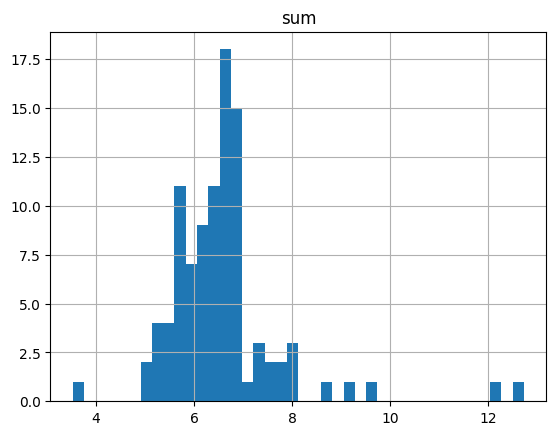

In [9]:
df.groupby(["FECHA_CIERRE"], )["DURACION_HR"].agg(["sum"]	).hist(bins=40)

<Axes: >

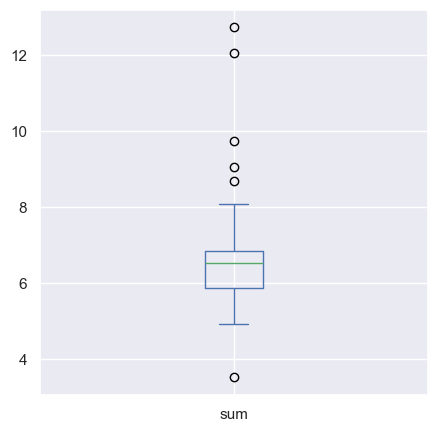

In [10]:
sns.set_theme(rc={'figure.figsize':(5,5)})
df.groupby(["FECHA_CIERRE"], )["DURACION_HR"].agg(["sum"]	).plot.box()

<Axes: xlabel='FECHA_CIERRE'>

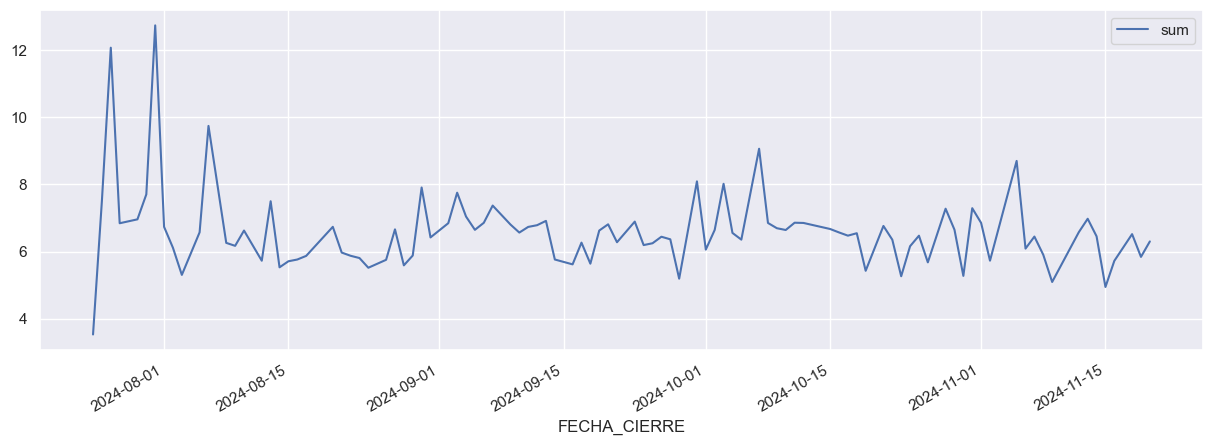

In [11]:
sns.set_theme(rc={'figure.figsize':(15,5)})
df.groupby(["FECHA_CIERRE"], )["DURACION_HR"].agg(["sum"]	).plot()

Conclusion. Distribución de cola derecha con valores extremos (anomalias) por encima de 500

<Axes: >

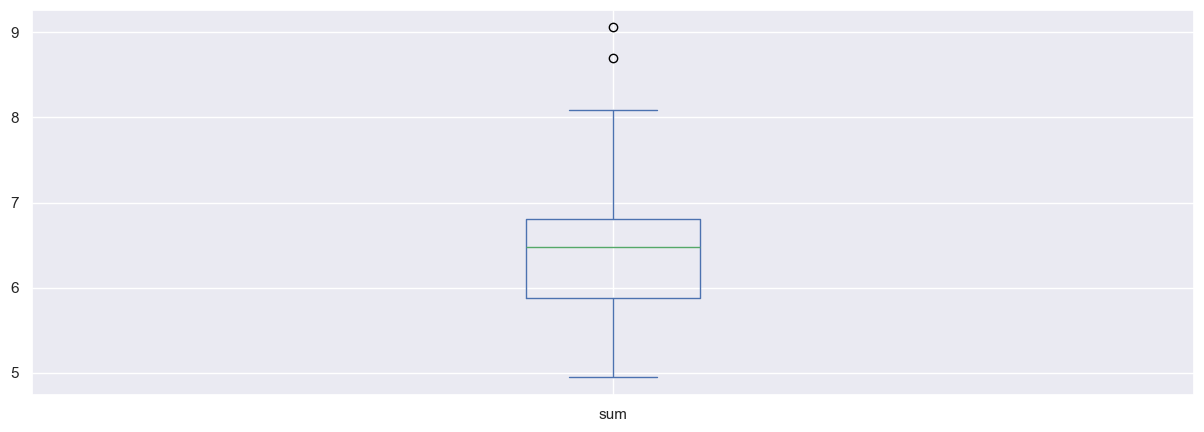

In [12]:
df_parcial=df.query("FECHA_CIERRE >= '2024-08-15'")
df_parcial.groupby(["FECHA_CIERRE"], )["DURACION_HR"].agg(["sum"]	).plot.box()

## Pausas

In [13]:
df_sum=df_parcial.groupby("FECHA_CIERRE", as_index=True)["DURACION_MIN"].agg(["max","sum"])
df_sum.rename(columns={"max":"TAREA_MAX","sum":"TOTAL"}, inplace=True)
df_sum_pausas=df_parcial[df_parcial.PAUSA].groupby("FECHA_CIERRE", as_index=False)["DURACION_MIN"].sum()
df_sum_pausas.set_index("FECHA_CIERRE", inplace=True)
df_sum_pausas.rename(columns={"DURACION_MIN":"DURACION_PAUSAS"},inplace=True)
df_sum=df_sum.join(df_sum_pausas,)
df_sum["SIN_PAUSA"]=df_sum.TOTAL - df_sum.DURACION_PAUSAS


<Axes: xlabel='FECHA_CIERRE'>

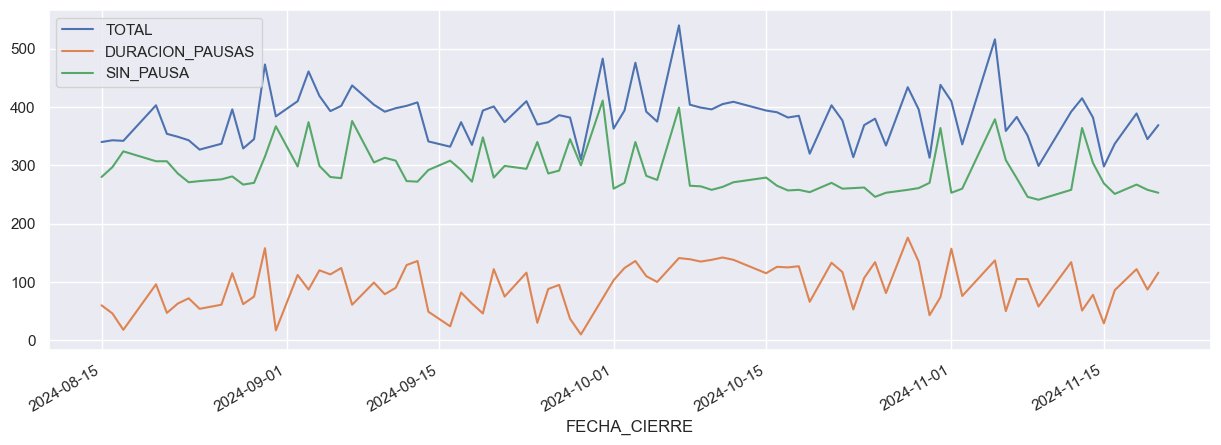

In [14]:
df_sum[['TOTAL','DURACION_PAUSAS','SIN_PAUSA']].plot(subplots=False)

Los datos antes del mes 9 tienen picos y no todos estaban asociados a pausas

<Axes: xlabel='FECHA_CIERRE'>

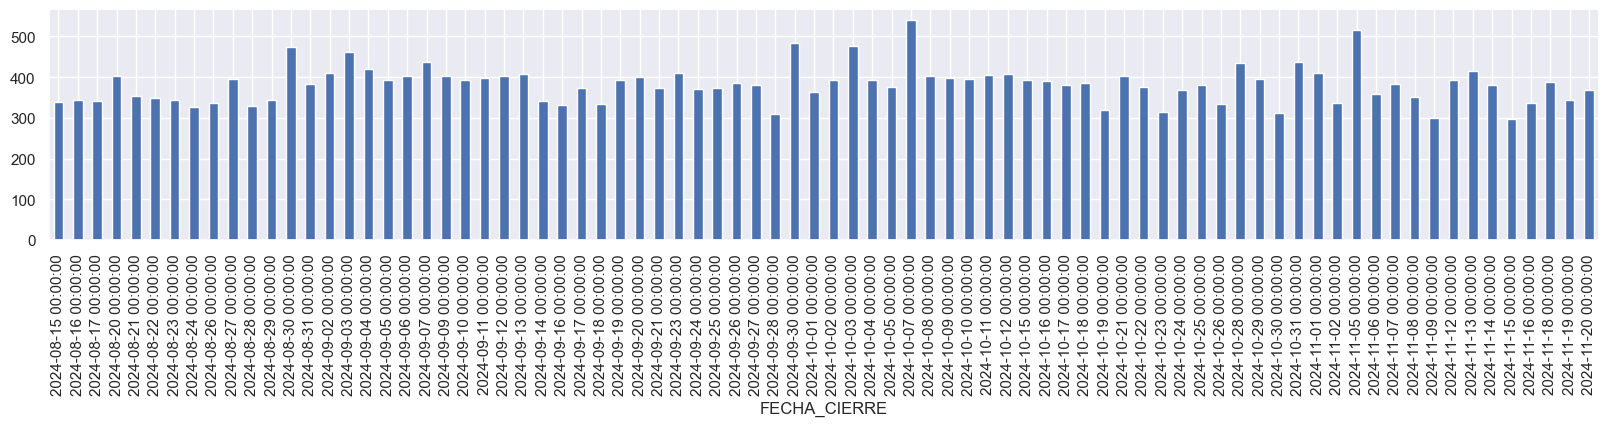

In [15]:
sns.set_theme(rc={'figure.figsize':(20,3)})
df_sum.query("index >= '2024-08-15' ")["TOTAL"].plot.bar()

<Axes: xlabel='FECHA_CIERRE'>

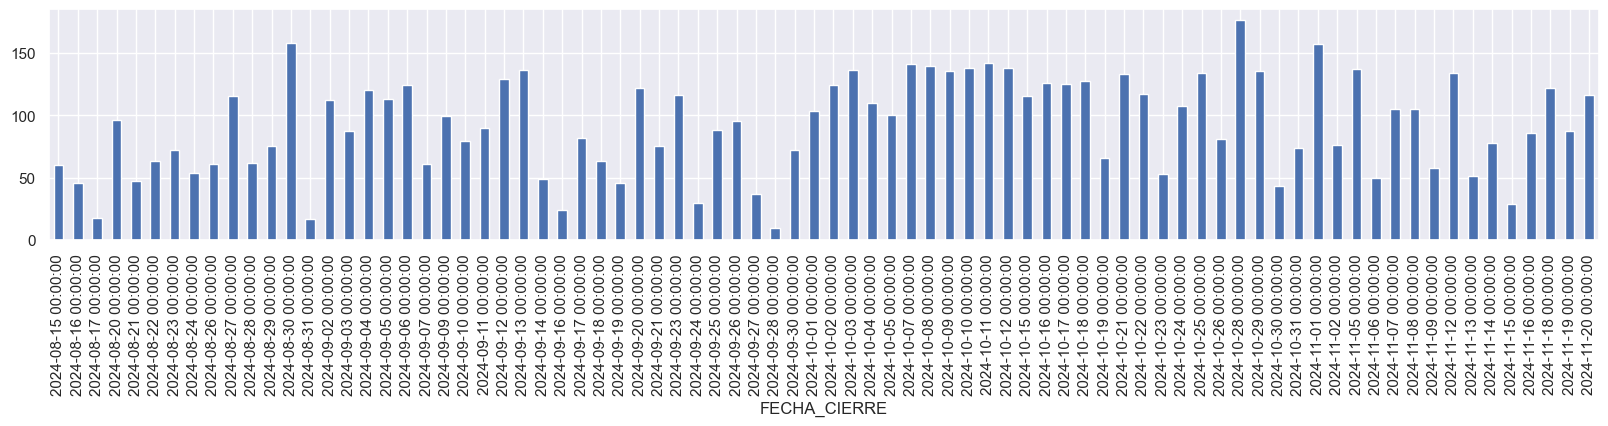

In [16]:
df_sum["DURACION_PAUSAS"].plot.bar()


<Axes: >

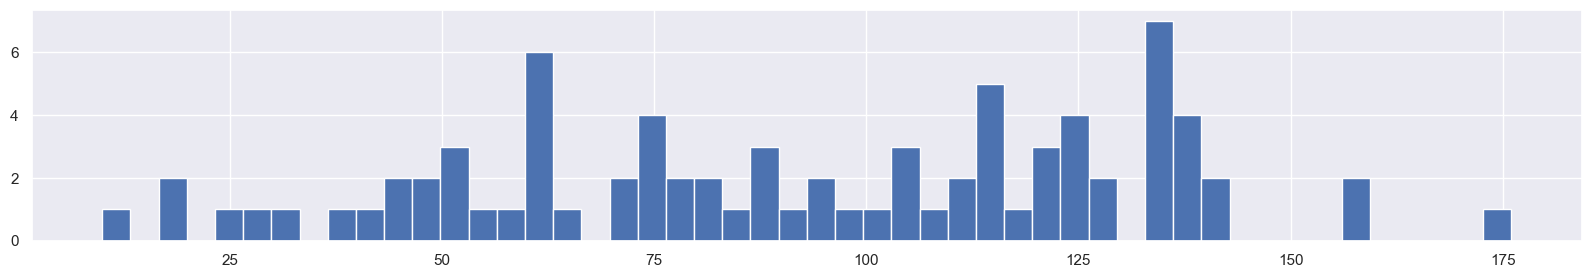

In [17]:
df_sum["DURACION_PAUSAS"].hist(bins=50)

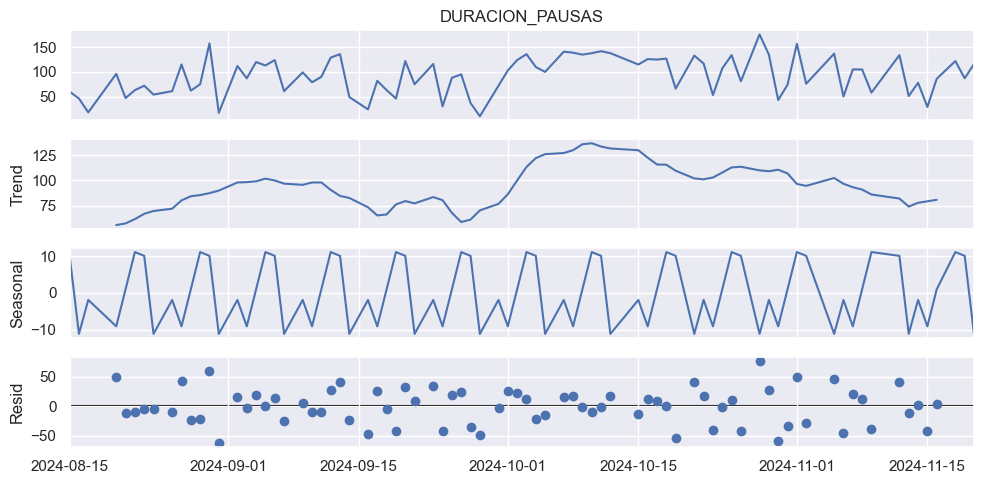

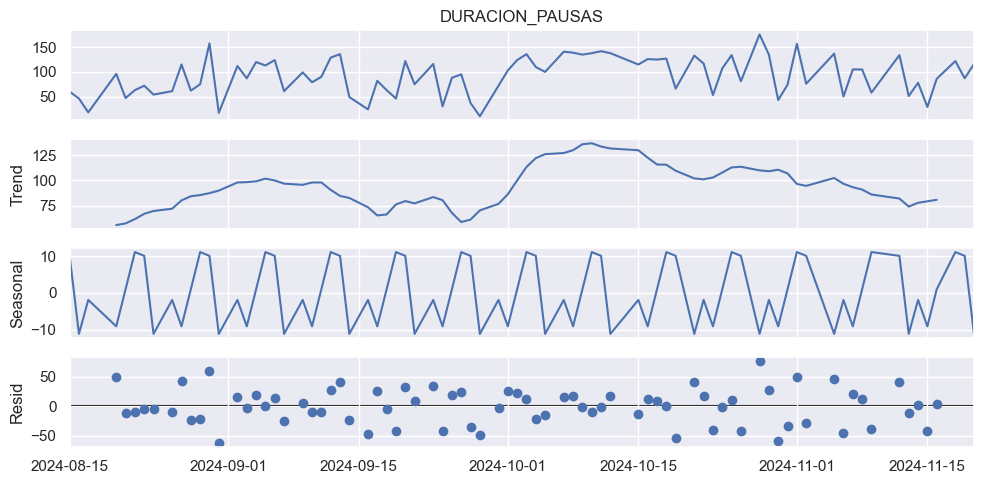

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
sns.set_theme(rc={'figure.figsize':(10,5)})
decompose_result_mult = seasonal_decompose(df_sum["DURACION_PAUSAS"], model="additive", period=6)

decompose_result_mult.plot()

In [22]:
df_sum["FECHA"]=df_sum.index
df_sum["POST_FESTIVO"]=df_sum.FECHA.isin(post_festivos)

C:\Users\juanm\AppData\Local\Temp\ipykernel_27464\3062257077.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_sum["POST_FESTIVO"]=df_sum.FECHA.isin(post_festivos)


In [23]:
df_sum[df_sum["POST_FESTIVO"]]

,TAREA_MAX,TOTAL,DURACION_PAUSAS,SIN_PAUSA,FECHA,POST_FESTIVO
FECHA_CIERRE,,,,,,
2024-08-20,86.0,403.0,96.0,307.0,2024-08-20,True
2024-10-15,96.0,394.0,115.0,279.0,2024-10-15,True
2024-11-05,110.0,516.0,137.0,379.0,2024-11-05,True
2024-11-12,95.0,392.0,134.0,258.0,2024-11-12,True


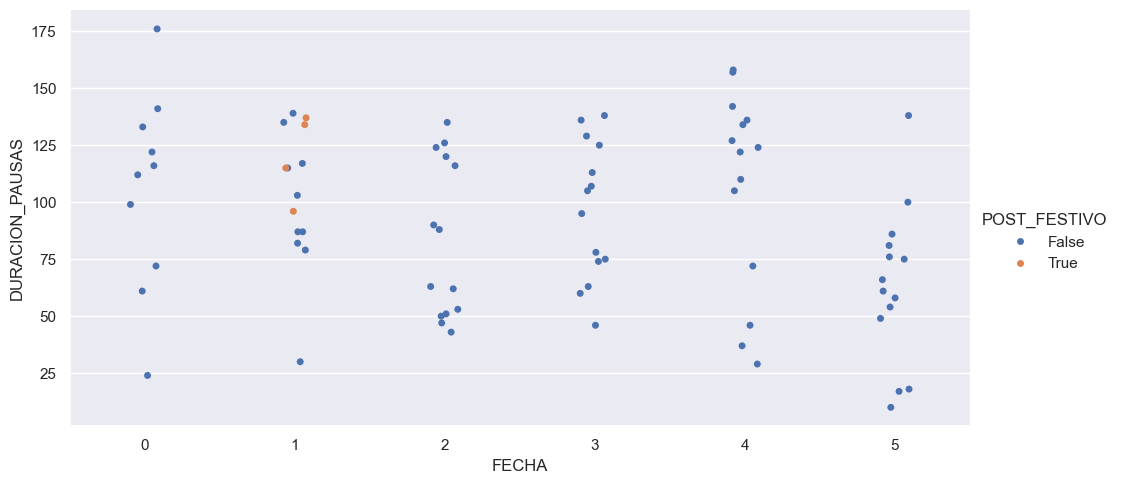

In [24]:
g=sns.catplot(x=df_sum["FECHA"].dt.day_of_week, y=df_sum["DURACION_PAUSAS"], hue=df_sum.POST_FESTIVO,  aspect=2)

### Conclusión
La duración total es la suma de la duración de las pausas y las tareas (no pausas). Existen valores extremos que se pueden atribuir a las pausas y otros valores relacionados con otra tareas
Las pausas tienen mucha variación en la duración, se ve un leve patron relacionado con el día de la semana pero no es se pudo comprobar con un modelo.

## Sin pausas

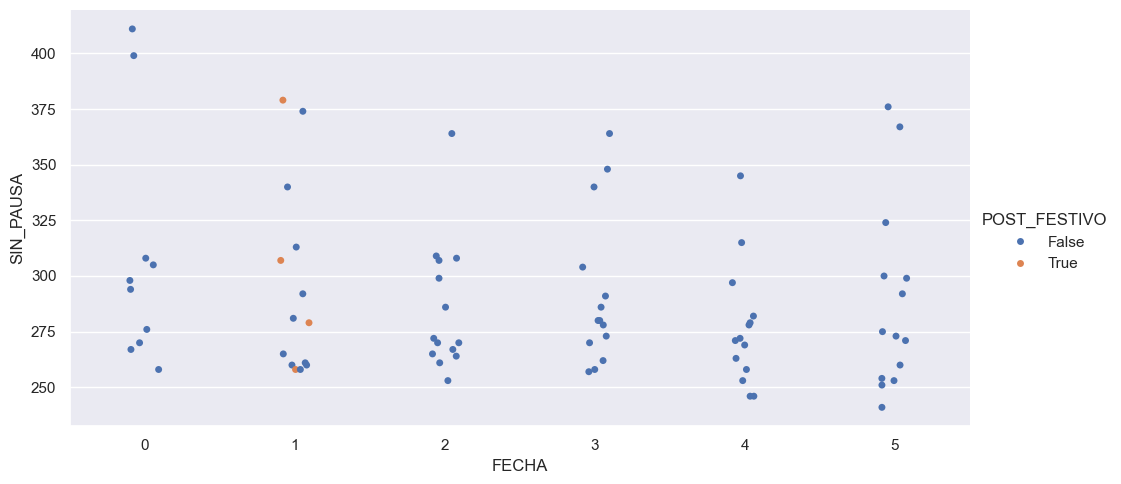

In [25]:
sns.set_theme(rc={'figure.figsize':(8,3)})
g=sns.catplot(x=df_sum["FECHA"].dt.day_of_week, y=df_sum["SIN_PAUSA"], hue=df_sum.POST_FESTIVO,  aspect=2)

### Conclusión
La variación en las tareas sin pausas también es alta. También se ve un leve patrón por los días de la semana pero los valores extremos superiores impiden caputurarlo en un modelo.
Los días festivos no parecen afectar la duración de las tareas sin pausas

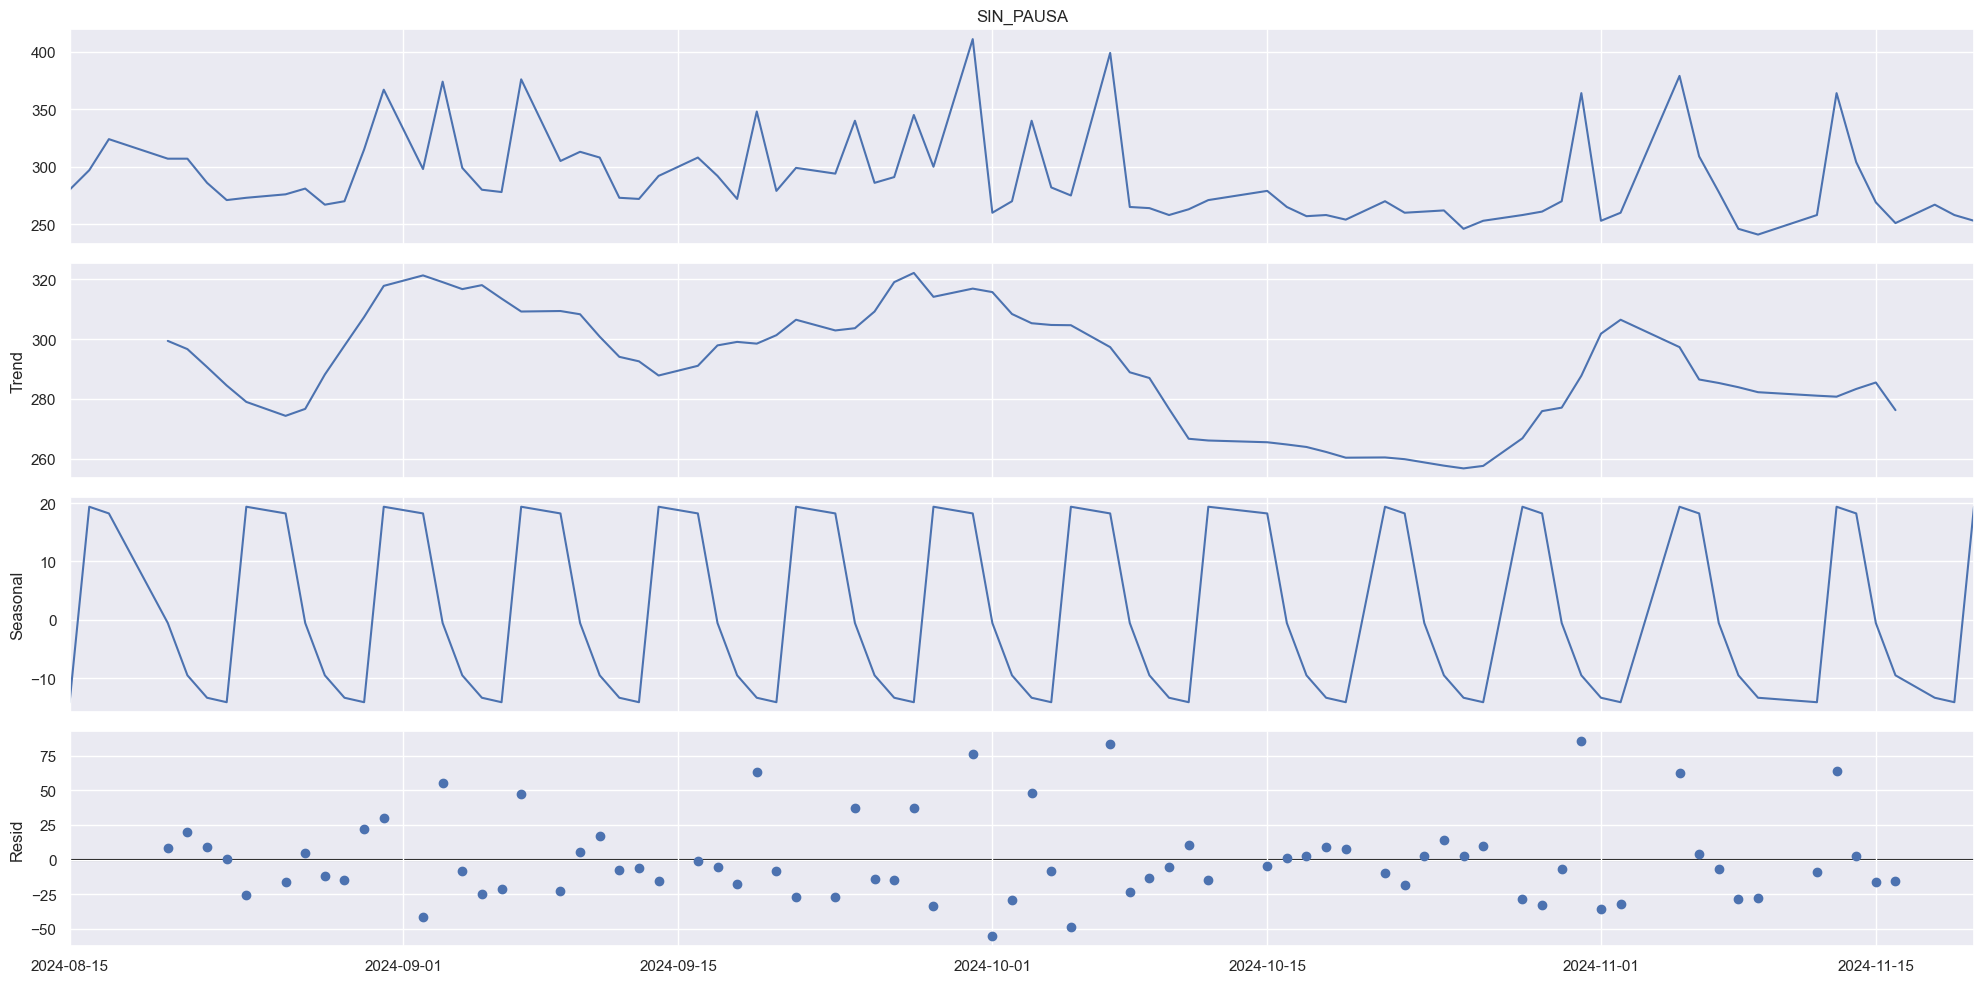

In [27]:
sns.set_theme(rc={'figure.figsize':(20,10)})
decompose_result_mult = seasonal_decompose(df_sum["SIN_PAUSA"], model="additive", period=6)

decompose_result_mult.plot();

## Tareas representativas

### Top tareas minutos totales

In [28]:
df_tareas_agg=df_parcial.groupby(["CODIGO_TAREA"], as_index=True,)["DURACION_MIN"].agg(["max","min","mean","median","count","sum"]	).sort_values("sum",ascending=False)


In [29]:
df_agg_top=df_tareas_agg.sort_values("sum",ascending=False).head(10)
df_agg_top

,max,min,mean,median,count,sum
CODIGO_TAREA,,,,,,
PAUSA,129.0,0.0,18.301235,4.0,405,7412.0
PBCGD017,42.0,27.0,34.475000,36.0,80,2758.0
PSNG9122,21.0,17.0,18.712500,19.0,80,1497.0
PJBWM077,22.0,14.0,17.737500,18.0,80,1419.0
PP017,30.0,12.0,16.937500,17.0,80,1355.0
PNU00217,32.0,7.0,16.787500,16.0,80,1343.0
PNU00002,22.0,10.0,15.787500,17.0,80,1263.0
PCC00003,26.0,11.0,14.237500,14.0,80,1139.0
PPP92005,45.0,9.0,13.750000,13.0,80,1100.0


In [30]:
lst_top=df_agg_top.index.to_list()
#sns.set_theme(rc={'figure.figsize':(20,2)})



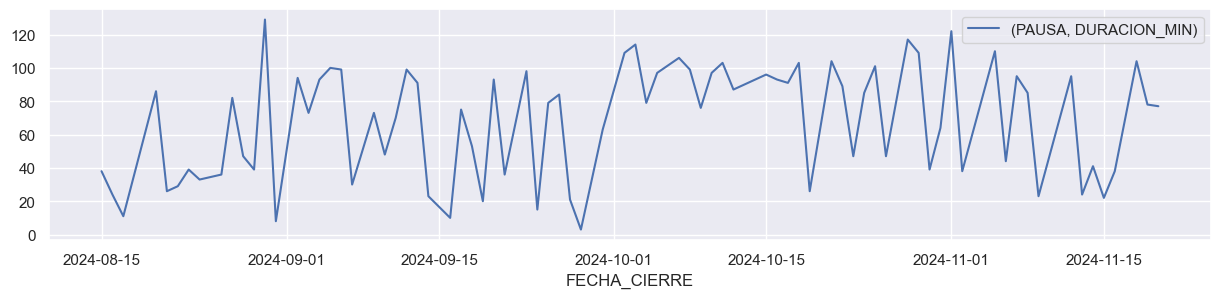

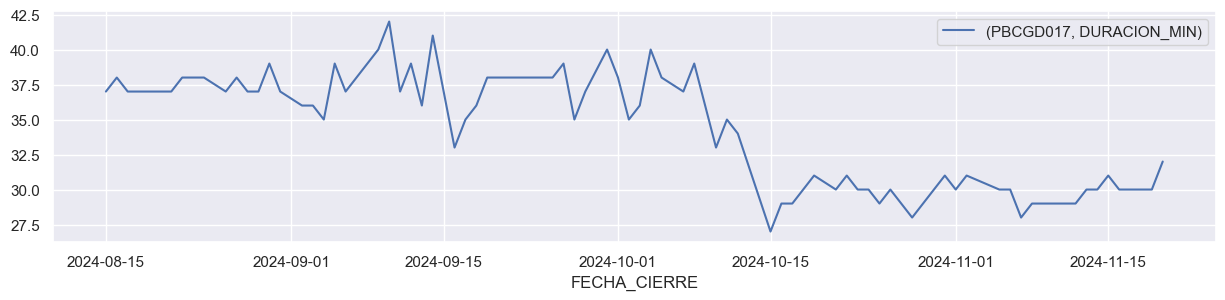

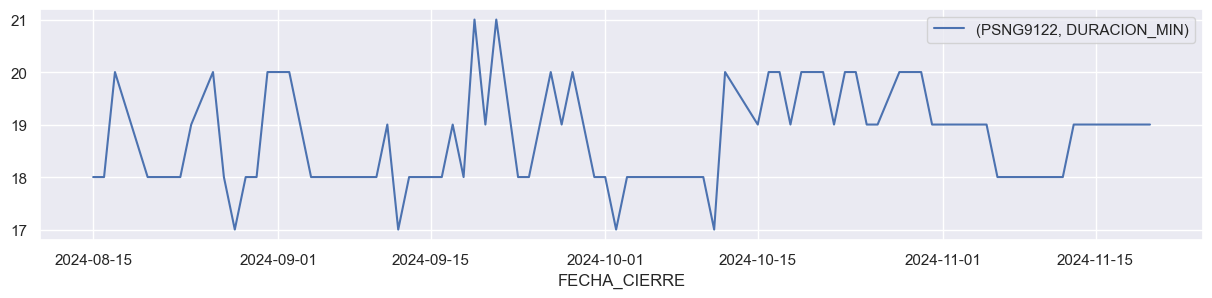

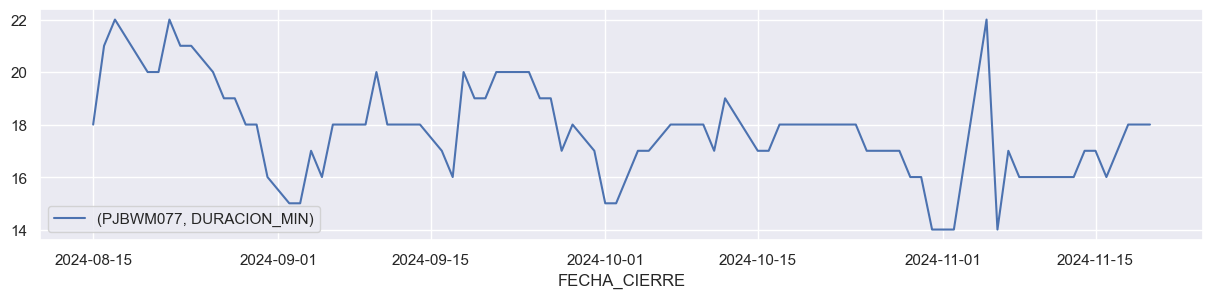

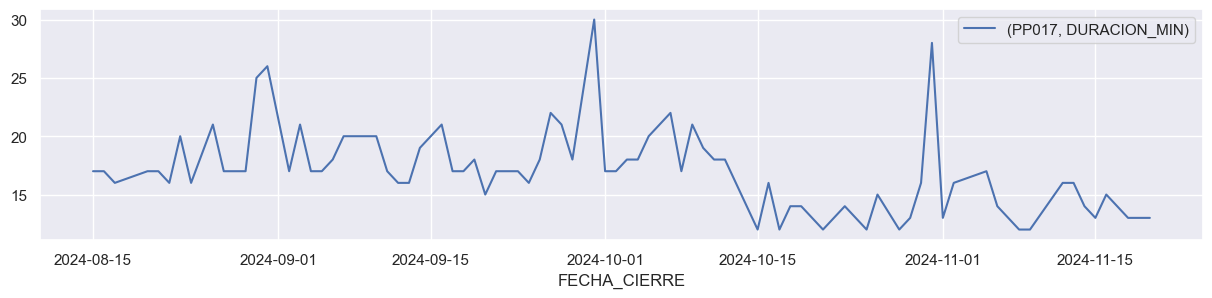

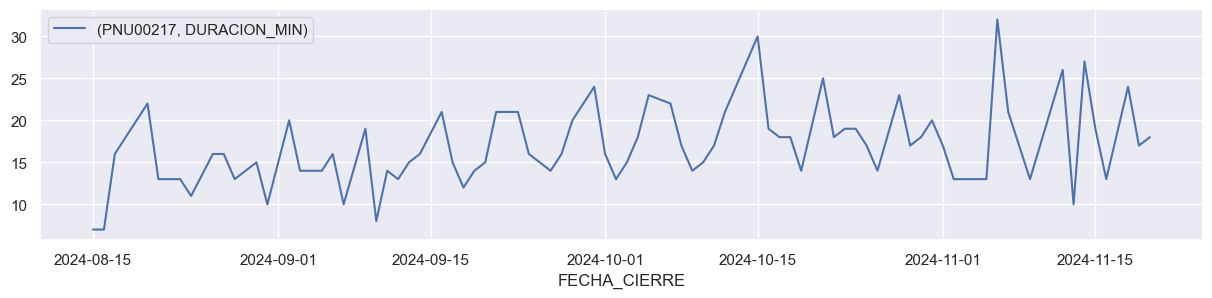

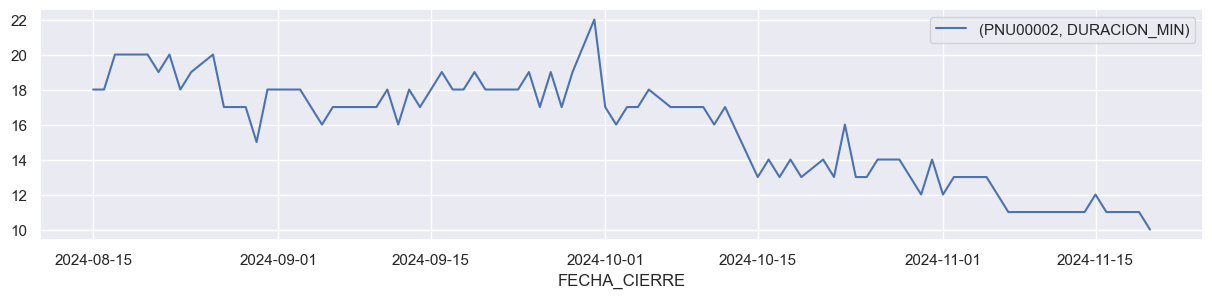

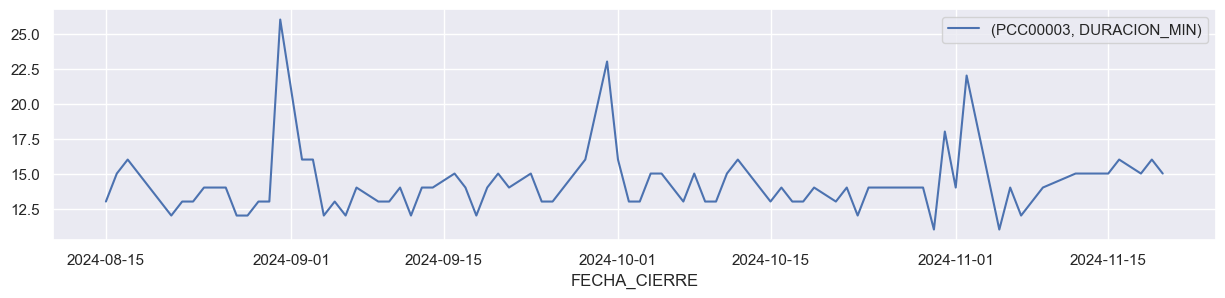

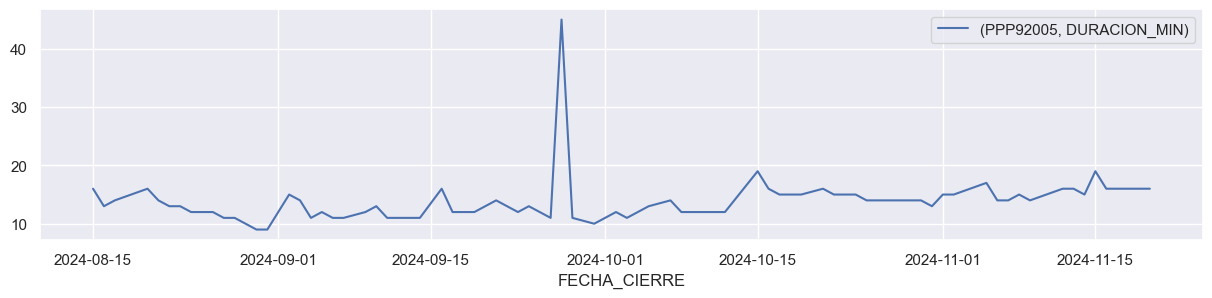

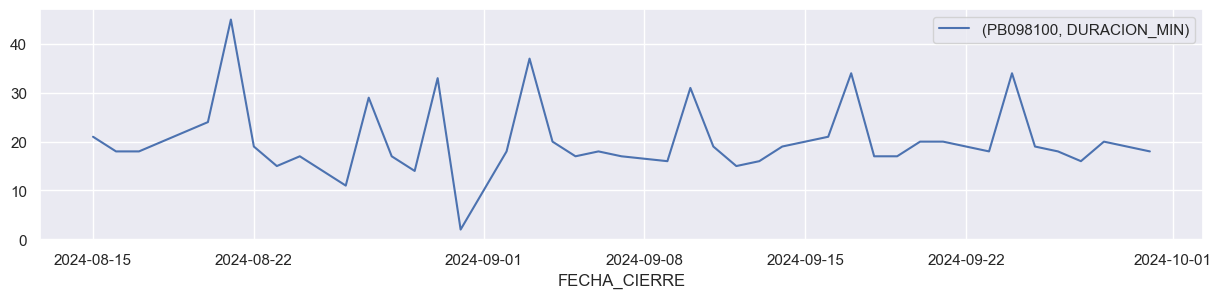

In [31]:
sns.set_theme(rc={'figure.figsize':(15,3)})
for tarea in df_tareas_agg.sort_values("sum",ascending=False).head(10).index:
     df_parcial[df_parcial["CODIGO_TAREA"]==tarea].groupby("FECHA_CIERRE")[["CODIGO_TAREA","DURACION_MIN"]].max().plot(by="CODIGO_TAREA")
    

### Ordenados por máximo

In [32]:
df_tareas_agg.sort_values("max",ascending=False).head(15)

,max,min,mean,median,count,sum
CODIGO_TAREA,,,,,,
PAUSA,129.0,0.0,18.301235,4.0,405,7412.0
PAHP900,66.0,0.0,0.825000,0.0,80,66.0
PP020FV2,59.0,1.0,5.725000,1.0,80,458.0
PNU00009,46.0,4.0,6.112500,5.0,80,489.0
PPP92005,45.0,9.0,13.750000,13.0,80,1100.0
PB098100,45.0,2.0,20.461538,18.0,39,798.0
PBCGD017,42.0,27.0,34.475000,36.0,80,2758.0
PP020A,37.0,3.0,7.587500,6.0,80,607.0
PNU00117,33.0,1.0,2.525000,1.0,80,202.0


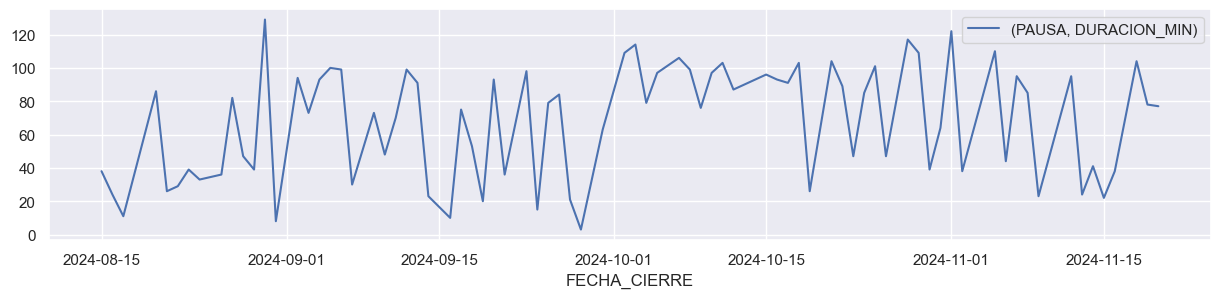

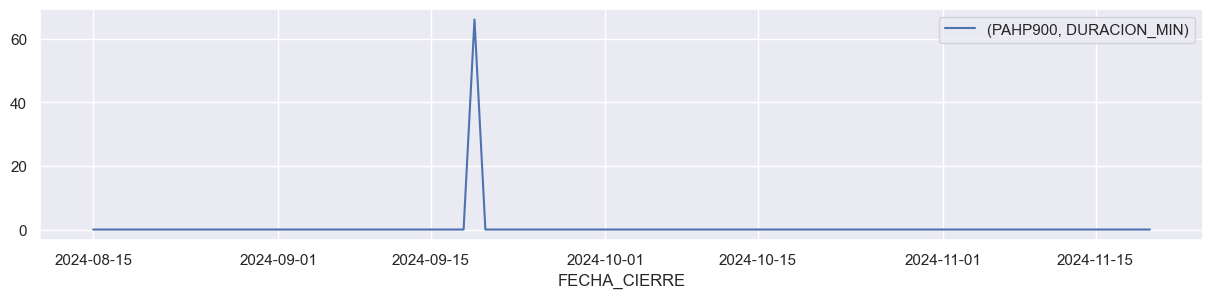

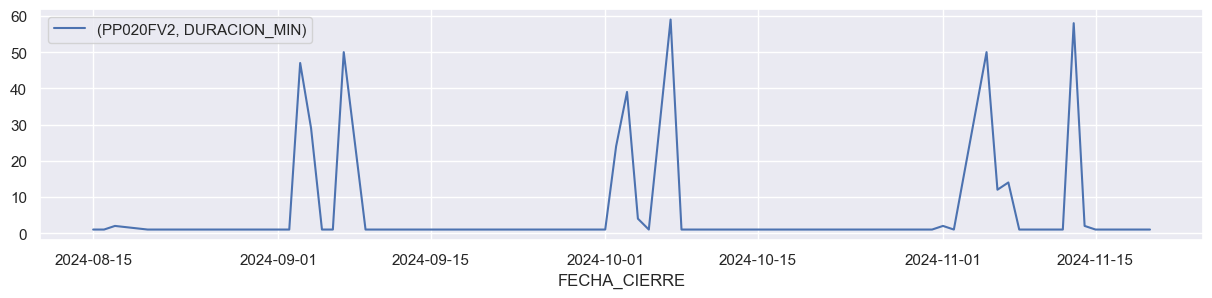

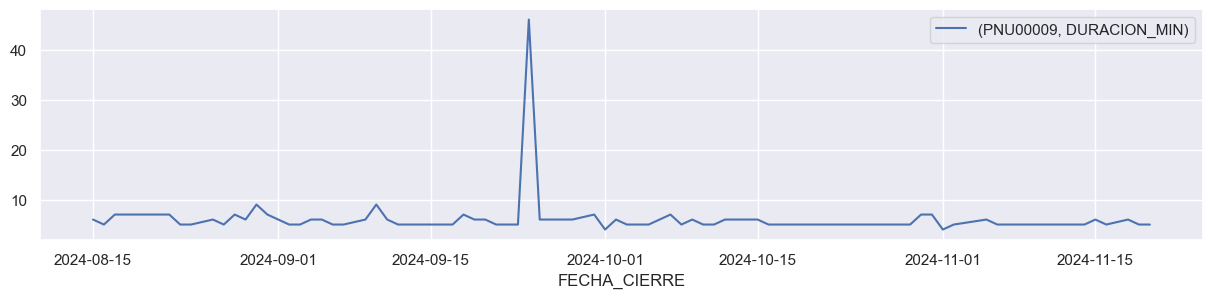

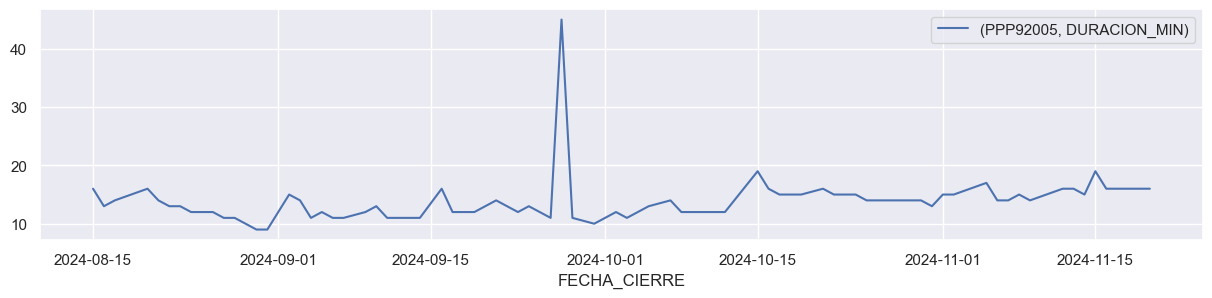

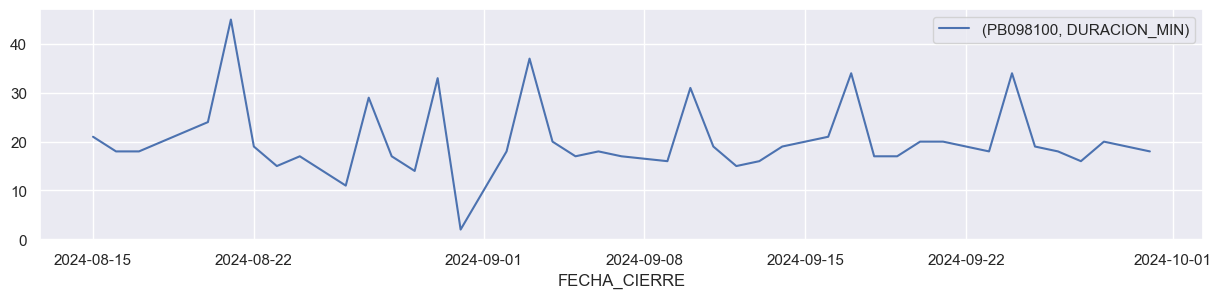

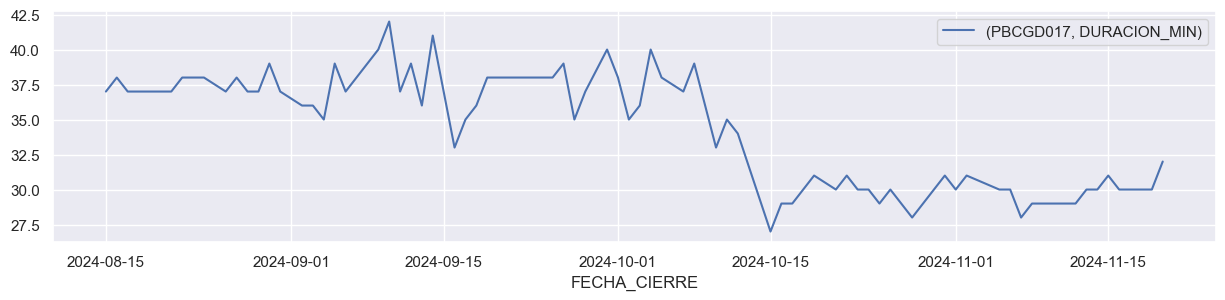

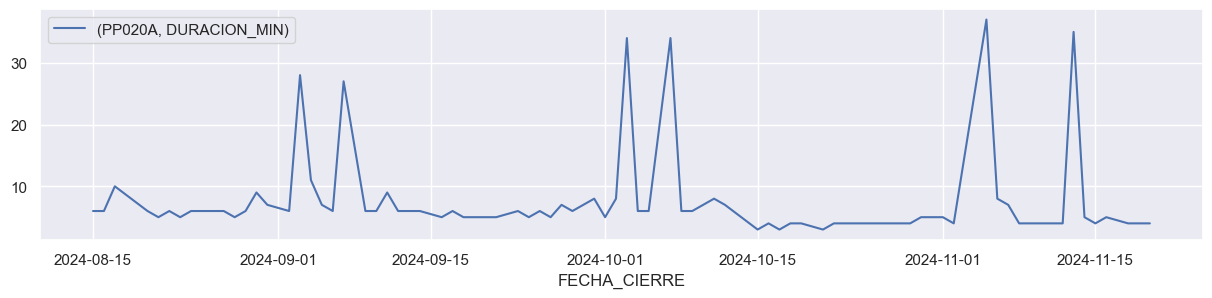

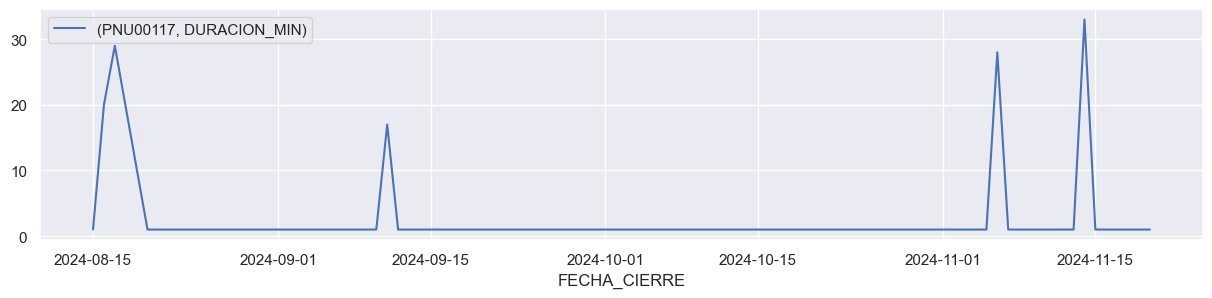

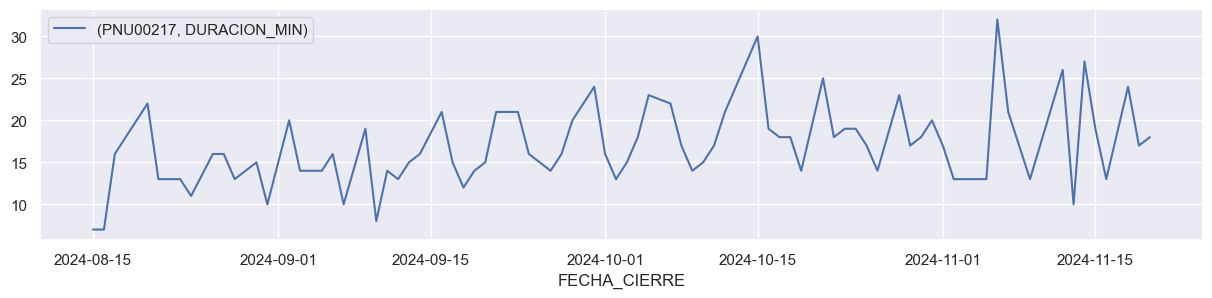

In [33]:

for tarea in df_tareas_agg.sort_values("max",ascending=False).head(10).index:
     df_parcial[df_parcial["CODIGO_TAREA"]==tarea].groupby("FECHA_CIERRE")[["CODIGO_TAREA","DURACION_MIN"]].max().plot(by="CODIGO_TAREA")
    

### Correlacion

In [34]:
df_tareas_agg.groupby("max").size()

max
0.0      67
1.0      23
2.0      14
3.0       3
4.0       6
5.0       4
6.0       4
7.0       1
8.0       1
9.0       3
10.0      3
11.0      1
12.0      1
13.0      1
15.0      1
21.0      1
22.0      3
26.0      1
28.0      1
30.0      1
31.0      1
32.0      1
33.0      1
37.0      1
42.0      1
45.0      2
46.0      1
59.0      1
66.0      1
129.0     1
dtype: int64

<Axes: xlabel='max'>

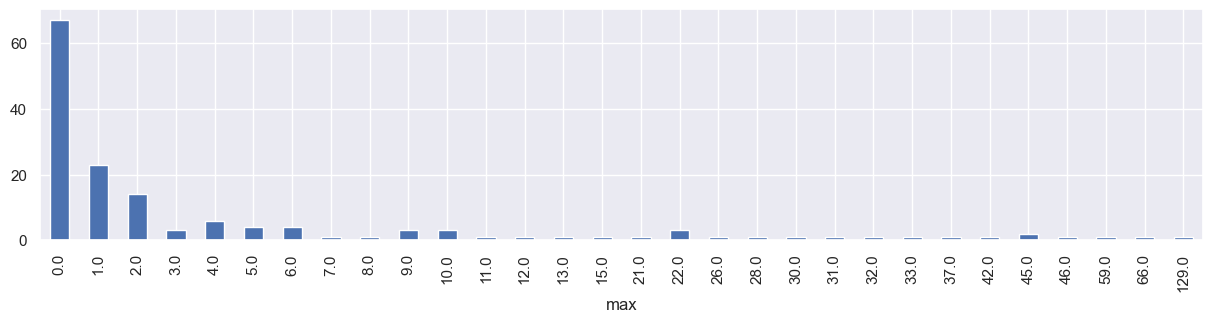

In [35]:
df_tareas_agg.groupby("max").size().plot.bar()


In [36]:
tareas_max5=df_tareas_agg[df_tareas_agg["max"]>5].index
tareas_max5
df_tareas_max5=df_parcial[df_parcial.CODIGO_TAREA.isin(tareas_max5)]

In [37]:
crosstab_df = pd.crosstab(df_tareas_max5['FECHA_CIERRE'], df_tareas_max5['CODIGO_TAREA'], values=df['DURACION_MIN'], aggfunc='sum').fillna(0)
crosstab_df.loc[:,"TOTAL"] = crosstab_df.sum(axis=1)
correlation_matrix = crosstab_df.corr()

<Axes: xlabel='CODIGO_TAREA', ylabel='CODIGO_TAREA'>

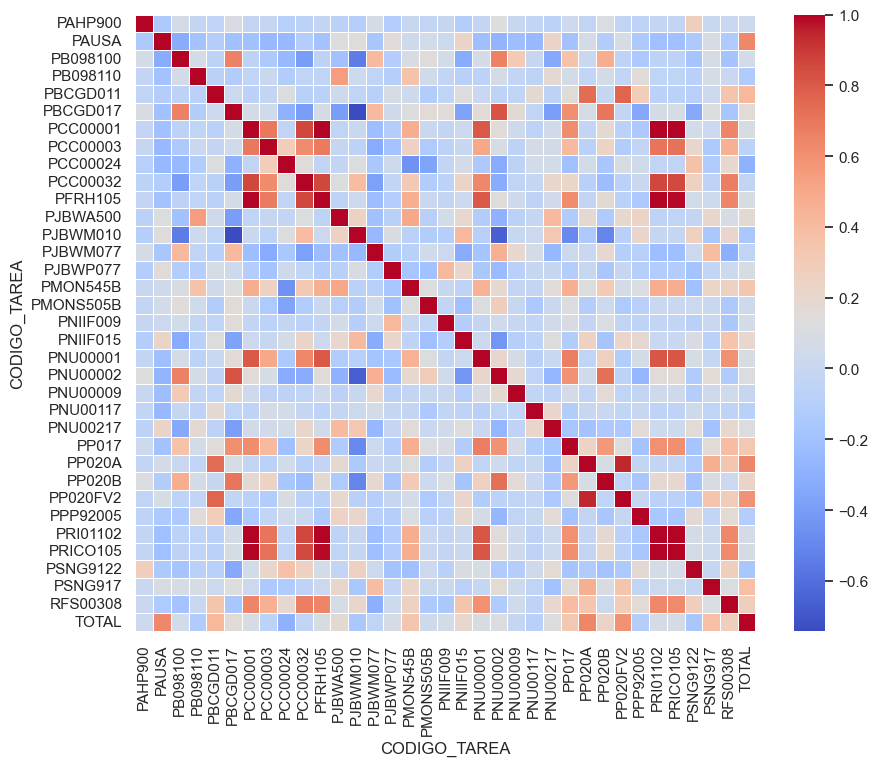

In [38]:

sns.set_theme(rc={'figure.figsize':(10,8)})

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)

In [39]:
lst_seleccion=['PCC00001','PRICO105','PRI01102','PFRH105']
crosstab_df[lst_seleccion][crosstab_df.PCC00001>0]

CODIGO_TAREA,PCC00001,PRICO105,PRI01102,PFRH105
FECHA_CIERRE,,,,
2024-08-31,11.0,9.0,6.0,12.0
2024-09-30,11.0,8.0,5.0,12.0
2024-10-31,11.0,7.0,5.0,13.0


<Axes: xlabel='FECHA_CIERRE'>

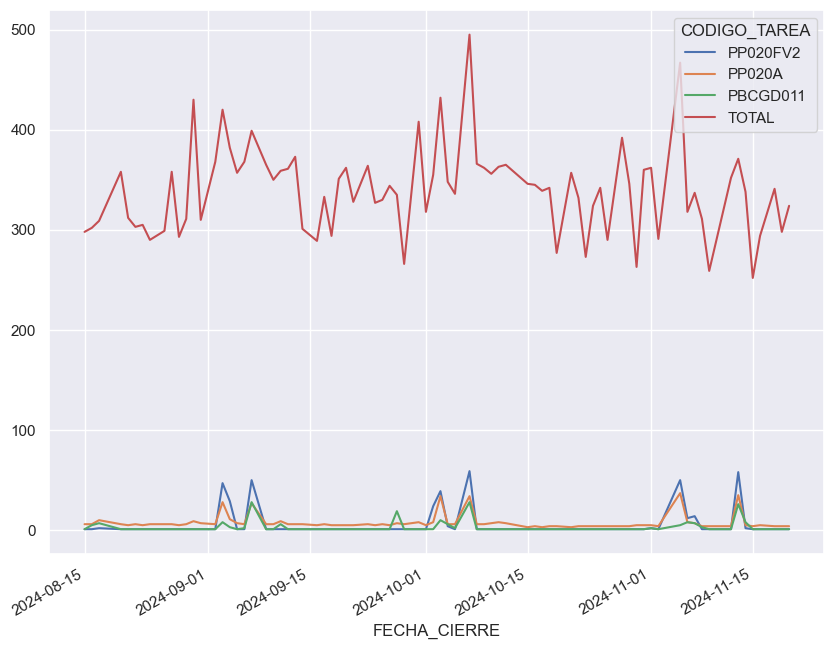

In [40]:
lst_seleccion=['PP020FV2','PP020A','PBCGD011',"TOTAL"]
crosstab_df[lst_seleccion].dropna(thresh=1).plot()
#for tarea in lst_seleccion:
#    df_parcial[df_parcial["CODIGO_TAREA"]==tarea].groupby("FECHA_CIERRE")[["CODIGO_TAREA","DURACION_MIN"]].max().plot(by="CODIGO_TAREA")


### Conclusión
Para el análisis de correlación se tomaron las tareas que han tenido tiempos máximos mayores a 5 minutos
se identificó que:
- las tareas 'PCC00001','PRICO105','PRI01102' estan relacionadas entre ellas porque se ejecutan al final de cada mes pero la duración es muy baja
- Las tareas tienen semejanza en los días de valores máximos 'PP020FV2','PP020A','PBCGD011' y parecen relacionados con la duraciones máximas de todo el proceso


### Agrupar tareas por comportamiento

In [41]:
df_crosstab_completo = pd.crosstab(df_parcial['CODIGO_TAREA'], df_parcial['FECHA_CIERRE'], values=df['DURACION_MIN'], aggfunc='sum').reset_index()
df_crosstab_completo.fillna(0,inplace=True) 
scaler = StandardScaler()
duraciones_normalizadas = scaler.fit_transform(df_crosstab_completo.iloc[:, 1:])


In [ ]:
dbscan = DBSCAN(eps=0.2, min_samples=3) 
clusters=dbscan.fit_predict(duraciones_normalizadas)
df_crosstab_completo["GRUPO"]=clusters

In [71]:
df_crosstab_completo.groupby("GRUPO").size() [df_crosstab_completo.groupby("GRUPO").size() > 1]

GRUPO
0     11
1    128
3      2
4      7
dtype: int64

In [44]:
sns.set_theme(rc={'figure.figsize':(20,3)})
df_crosstab_completo.set_index('CODIGO_TAREA', inplace=True)


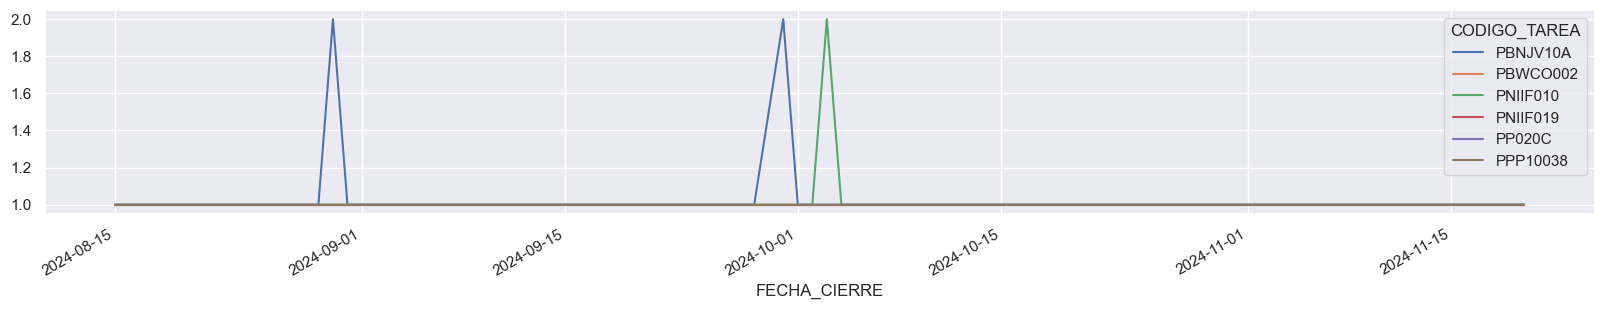

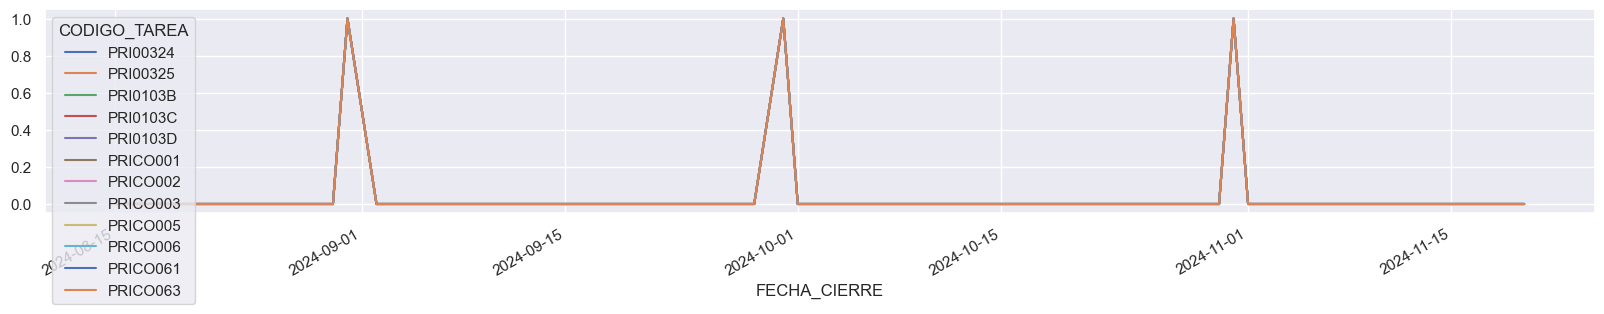

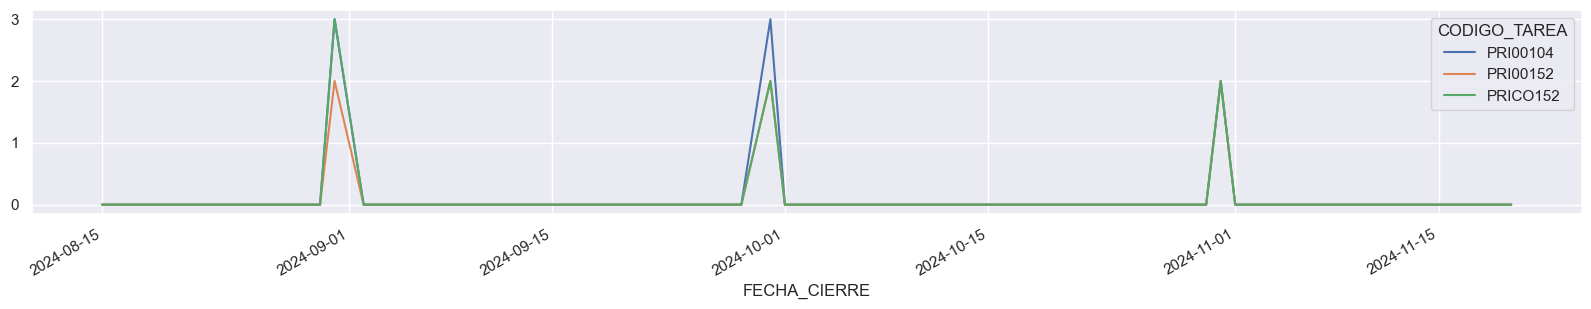

In [45]:
for grupo in [1,2,3]:
   (df_crosstab_completo[df_crosstab_completo.GRUPO==grupo]).transpose().drop(index=["GRUPO"]).plot()


In [46]:
# Seleccionar un número de clusters y aplicar K-means
kmeans = KMeans(n_clusters=7, random_state=42)  # Cambiar el número según el método del codo
clusters = kmeans.fit_predict(duraciones_normalizadas)
df_crosstab_completo["GRUPO"]=clusters
df_crosstab_completo.groupby("GRUPO").size()
#df_crosstab_completo.set_index('CODIGO_TAREA',inplace=True)


GRUPO
0     11
1    128
2      1
3      2
4      7
5      1
6      1
dtype: int64

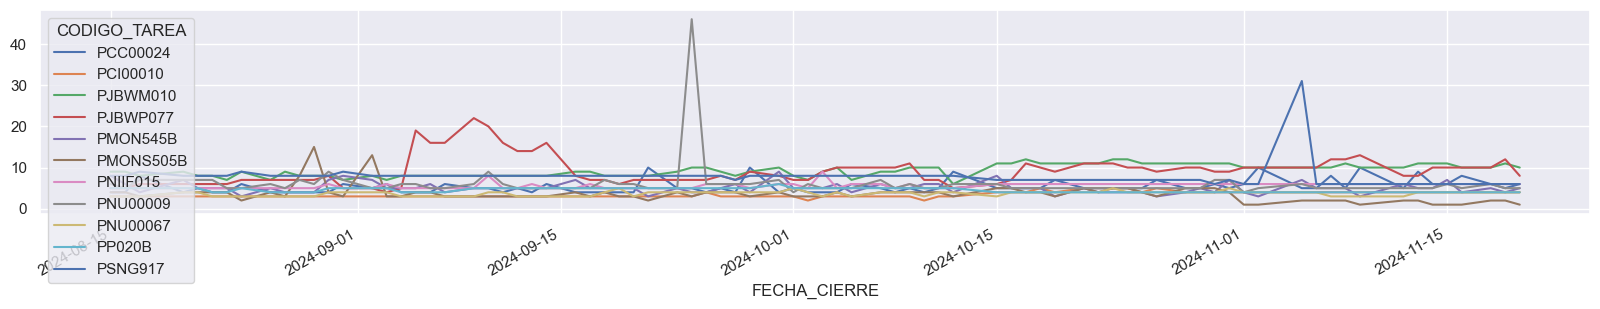

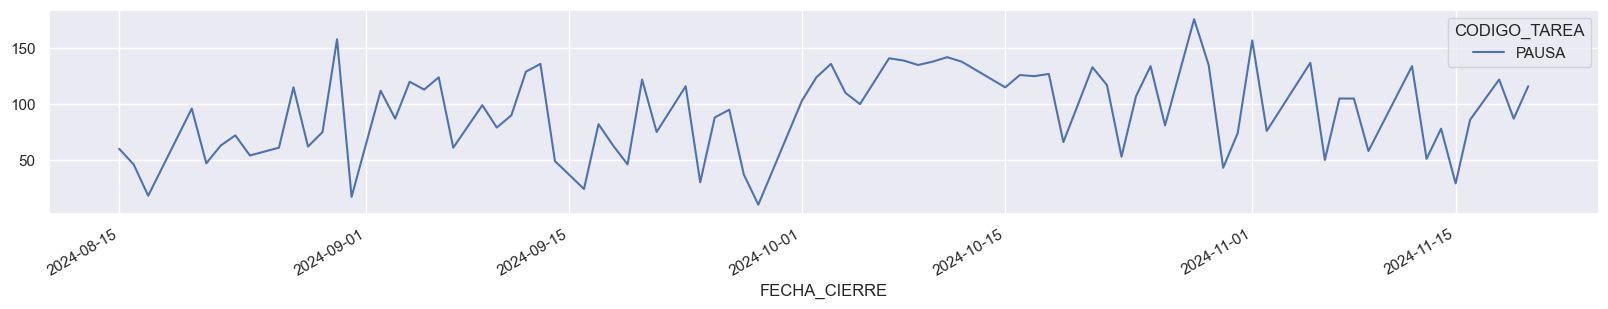

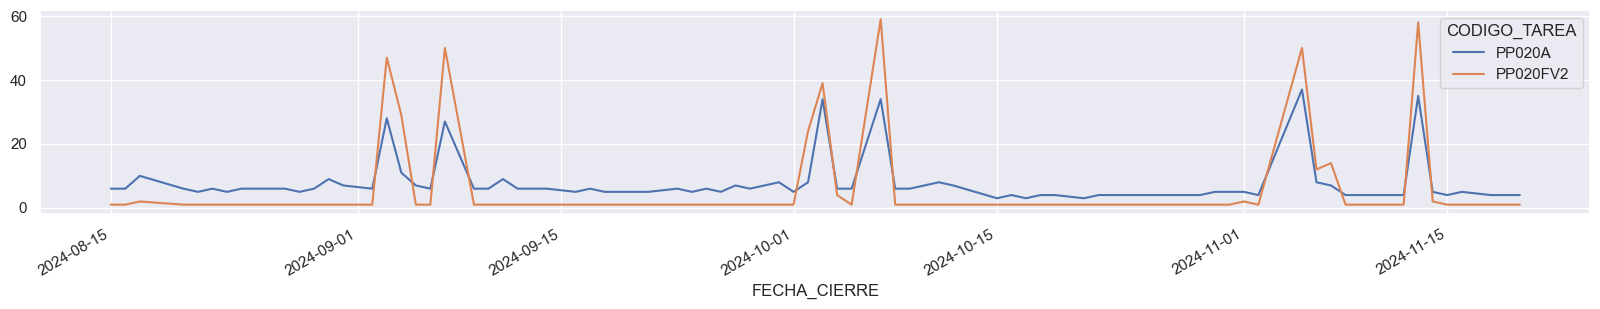

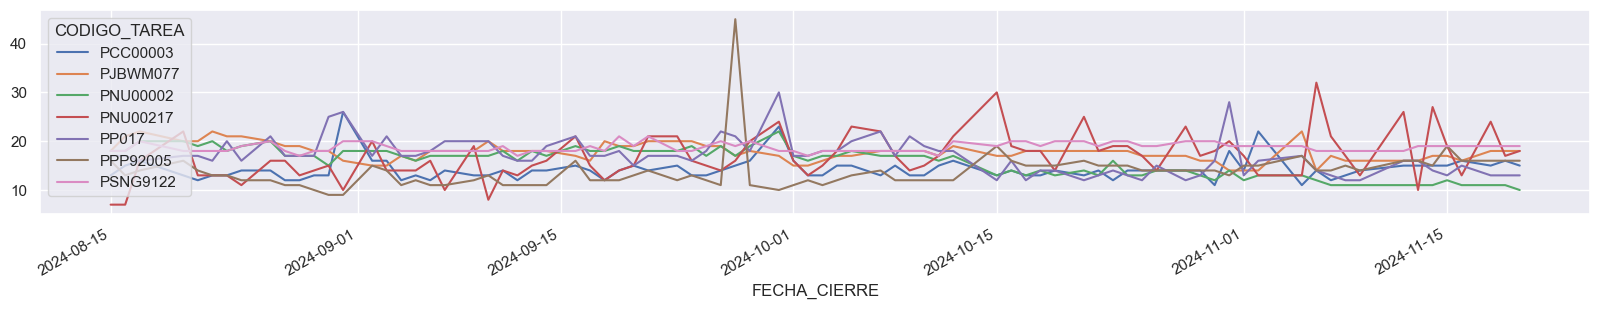

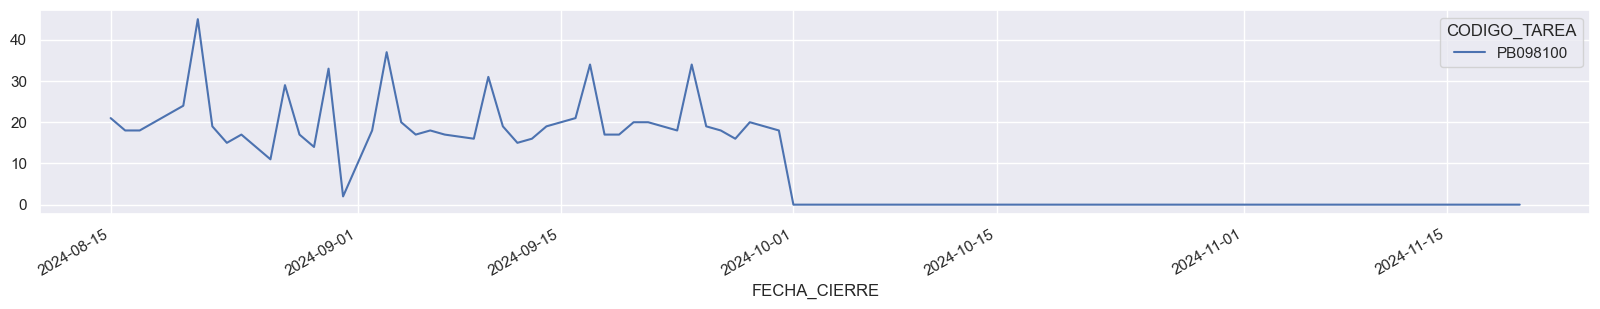

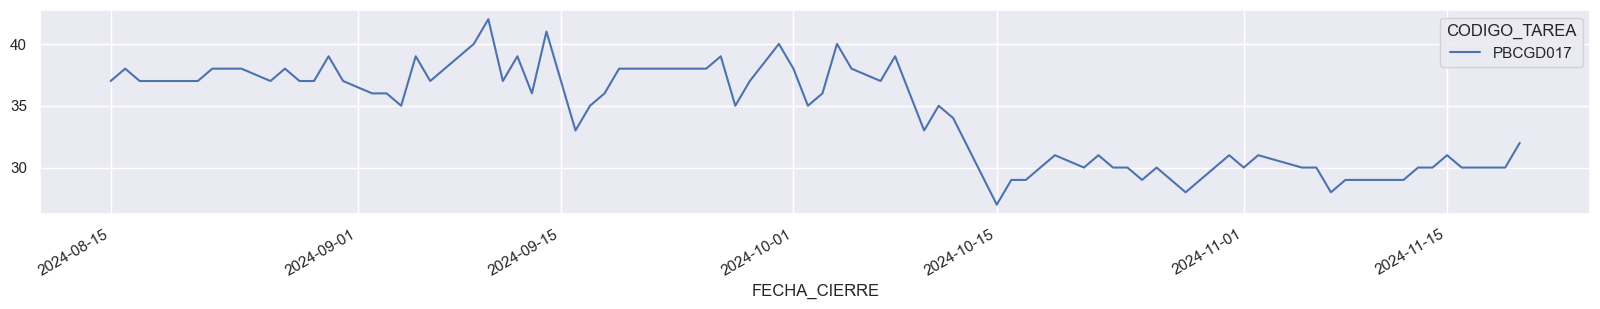

In [ ]:
sns.set_theme(rc={'figure.figsize':(20,3)})
for grupo in range(7):
    if grupo  not in (1,):
        (df_crosstab_completo[df_crosstab_completo.GRUPO==grupo]).transpose().drop(index=["GRUPO"]).plot()


### Conclusión
Con los modelos de agrupamiento no se logró identificar grupos de tareas que se tengan aumentos o disminuciones de duración el mismo día (correlacionadas).
Las principales agrupaciones fueron entre proceso cuya duración son inferiores al minuto.
Se crean grupo individuales para las tareas que tienen máximos algunos días del mes, como:
```
PAHP900 	66 mins 1 vez en 3 meses
PP020FV2	60 mins 2 veces al mes
PP020A		60 mins 2 veces al mes
PBCGD011	60 mins 2 veces al mes
PPP92005	45.0	1 vez en los 3 meses
PB098100	40 o más 1 vez cada semana
PPP92005	45.0 una vez al mes

PNU00117    30 mins 2 veces al mes
PNU00217    30 mins 2 veces al mes
PP020A		60 mins 2 veces al mes
PBCGD011	60 mins 2 veces al mes

PBCGD017    por debajo de 40 mins hace un mes
```

In [ ]:
lst_representativas = [
    'PAHP900',
'PP020FV2',
'PP020A',
'PBCGD011',
'PPP92005',
'PB098100',
'PPP92005',
'PNU00117',
'PNU00217',
'PP020A',
]


In [75]:

lst_representativas = [
'PP020FV2',
'PP020A',
'PNU00117',
'PNU00217',
'PB098100'
]


In [76]:

df_rep=df_parcial[df_parcial.CODIGO_TAREA.isin(lst_representativas)].groupby("FECHA_CIERRE", as_index=False)["DURACION_MIN"].sum()
df_rep.set_index("FECHA_CIERRE", inplace=True)
df_rep.rename(columns={"DURACION_MIN":"REPRESENTATIVAS"},inplace=True)
df_sum2=df_sum.join(df_rep)


<Axes: xlabel='FECHA_CIERRE'>

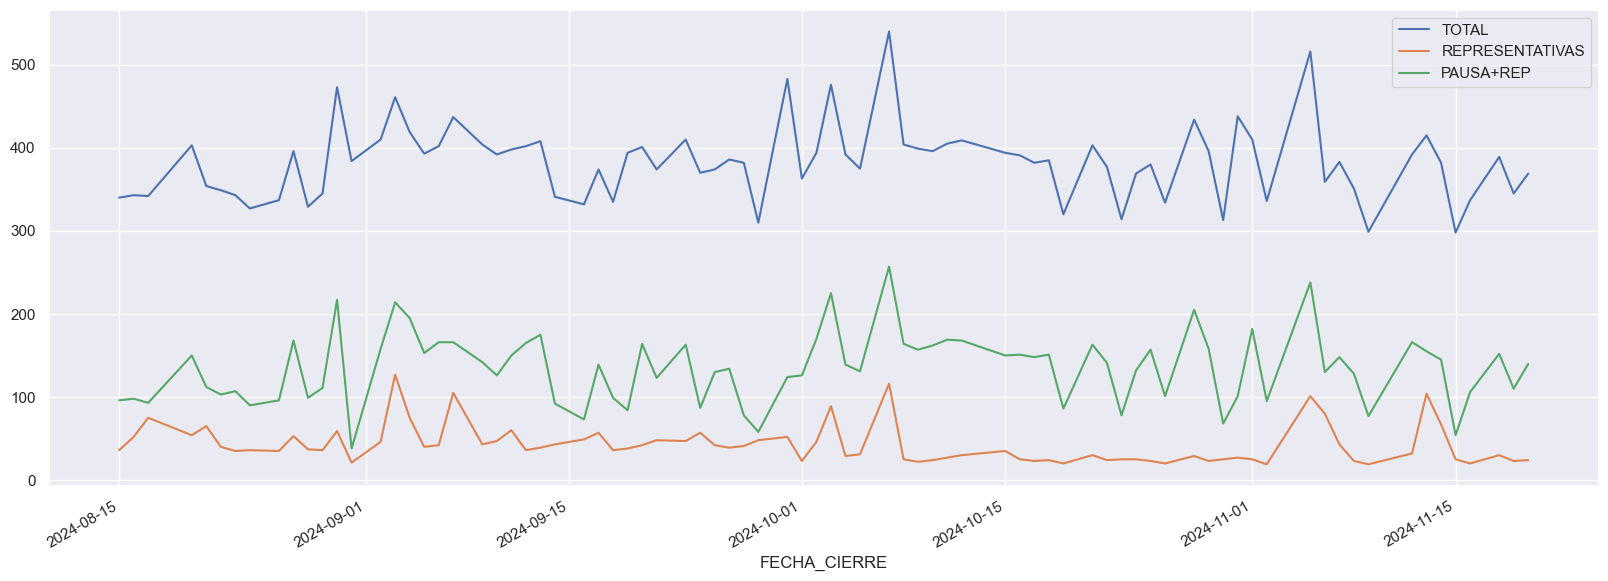

In [81]:
df_sum2["PAUSA+REP"]=df_sum2.DURACION_PAUSAS + df_sum2.REPRESENTATIVAS
df_sum2["PORCENTAJE"]=df_sum2["PAUSA+REP"]/df_sum2["TOTAL"]*100
df_sum2["DIF"]=df_sum2["TOTAL"]-df_sum2["PAUSA+REP"]

sns.set_theme(rc={'figure.figsize':(20,7)})
df_sum2[["TOTAL","REPRESENTATIVAS","PAUSA+REP",]].plot()


<Axes: xlabel='FECHA_CIERRE'>

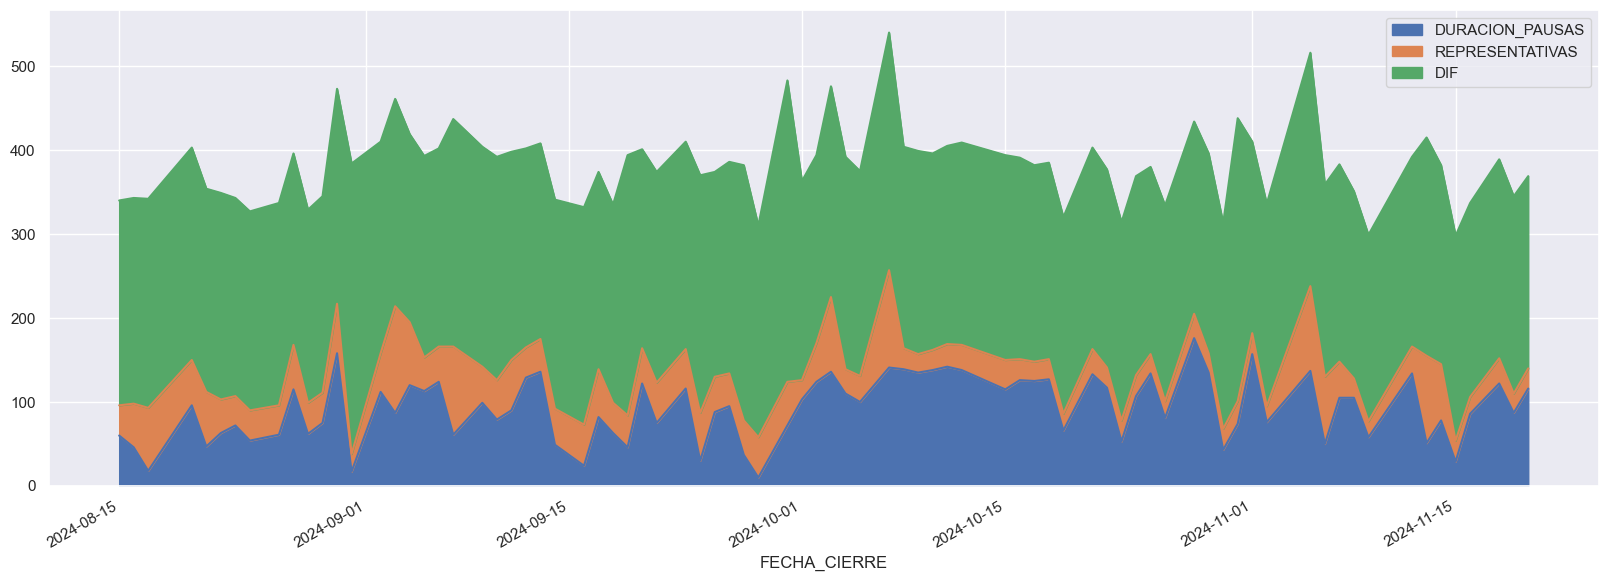

In [82]:
df_sum2[["DURACION_PAUSAS","REPRESENTATIVAS","DIF",]].plot.area()

In [78]:
df_sum2[["TOTAL","DURACION_PAUSAS","REPRESENTATIVAS","PAUSA+REP","PORCENTAJE","DIF"]]

,TOTAL,DURACION_PAUSAS,REPRESENTATIVAS,PAUSA+REP,PORCENTAJE,DIF
FECHA_CIERRE,,,,,,
2024-08-15,340.0,60.0,36.0,96.0,28.235294,244.0
2024-08-16,343.0,46.0,52.0,98.0,28.571429,245.0
2024-08-17,342.0,18.0,75.0,93.0,27.192982,249.0
2024-08-20,403.0,96.0,54.0,150.0,37.220844,253.0
2024-08-21,354.0,47.0,65.0,112.0,31.638418,242.0
...,...,...,...,...,...,...
2024-11-15,298.0,29.0,25.0,54.0,18.120805,244.0
2024-11-16,337.0,86.0,20.0,106.0,31.454006,231.0
2024-11-18,389.0,122.0,30.0,152.0,39.074550,237.0


In [70]:
df_parcial[df_parcial.CODIGO_TAREA.isin(lst_representativas)][["CODIGO_TAREA","DESCRIPCION_TAREA"]].value_counts()

CODIGO_TAREA  DESCRIPCION_TAREA             
PNU00117      Pasaje Resultados FVC             80
PNU00217      Pasaje Resultados M/E a M/N Ac    80
PP020A        Pasaje a Historico FSH015-16 *    80
PP020FV2      PASAJE A HISTORICOS DE MOVIMI     80
Name: count, dtype: int64